## Geographical data


/home/david/miniconda3/envs/tau/lib/python3.11/site-packages/geopandas/geoseries.py:574: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/home/david/miniconda3/envs/tau/lib/python3.11/site-packages/geopandas/plotting.py:48: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


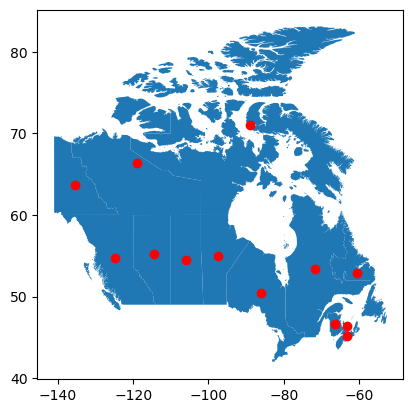

In [4]:
import geopandas as gpd

canada_gdf = gpd.read_file("data/canada/canada.geojson")
canada_gdf["centroid"]= canada_gdf["geometry"].apply(lambda x: x.centroid)
ax = canada_gdf.plot()
ax.scatter(canada_gdf["centroid"].x,canada_gdf["centroid"].y, color="red")
# this is used to get the weather data

## Gathering historical energy shares from nrcan

In [21]:
import requests
from data.canada import Provinces
prov_abbr = [p.name.lower() for p in Provinces]
prov_abbr
for prov in prov_abbr:
    url = f"https://oee.nrcan.gc.ca/corporate/statistics/neud/dpa/data_e/downloads/comprehensive/Excel/2020/res_{prov}_e_2.xls"
    response = requests.get(url)
    if response.status_code == 200:
        with open(f"{prov}.xls","wb") as fo:
            fo.write(response.content)
    else:
        print(f"Error: {response.status_code} for {prov}")

Error: 404 for nu
Error: 404 for nt
Error: 404 for yt


In [2]:
from data.canada import Provinces
prov_abbr = [p.name.lower() for p in Provinces]

import pandas as pd

prov_dfs = []
for prov in prov_abbr:
    try:
        df = pd.read_excel(f"{prov}.xls", header=10, index_col=1).drop(columns=["Unnamed: 0"])

        keep_rows = ~df.iloc[:,0].isna()
        df = df.loc[keep_rows,:]
        df["province"] = prov
        prov_dfs.append(df)
    except FileNotFoundError:
        print(f"File not found: {prov}.xls")


File not found: nu.xls
File not found: nt.xls
File not found: yt.xls


In [3]:
all_provinces_df = pd.concat(prov_dfs).reset_index().set_index(["province","index"])
valid_provs = all_provinces_df.index.get_level_values(0).unique()

In [7]:
all_provinces_df = all_provinces_df.reset_index()
for prov in valid_provs:
    full_prov_name = getattr(Provinces, prov.upper())
    all_provinces_df.loc[all_provinces_df["province"] == prov, "province"] = full_prov_name.value
all_provinces_df.head()

province                  index        2000        2001        2002  \
0  Alberta  Total Energy Use (PJ)  191.287287  172.229202  189.753525   
1  Alberta          Space Heating  129.354293  109.897501  125.597115   
2  Alberta          Water Heating   40.143670   38.519403   39.932431   
3  Alberta             Appliances   16.371148   17.758458   17.948250   
4  Alberta               Lighting    5.357538    5.939873    6.060255   

         2003        2004        2005        2006        2007  ...  \
0  190.990000  190.468961  177.687157  180.631783  210.340116  ...   
1  126.551963  124.982063  112.281967  115.007472  138.023797  ...   
2   41.653074   42.480270   42.072077   41.311922   47.400116  ...   
3   16.843408   17.075159   17.365945   17.920086   18.478491  ...   
4    5.767952    5.809380    5.900140    6.029337    6.086117  ...   

         2011        2012        2013        2014        2015        2016  \
0  206.628000  205.506000  207.430415  207.558334  201.199000  177.307592   
1  134.482424  133.461557  136.774303  138.350851  129.940512  112.760950   
2   46.650604   46.522575   45.102172   43.320560   44.981458   38.811795   
3   19.217233   19.338500   19.556548   19.841032   20.213999   19.983799   
4    6.091246    6.006779    5.843092    5.789150    5.733212    5.629053   

         2017        2018        2019        2020  
0  209.799529  217.519359  217.719789  215.665468  
1  137.751822  147.708121  147.577372  141.827502  
2   46.193291   44.590778   43.718298   45.532896  
3   20.007068   19.598546   20.776689   22.089604  
4    5.503333    5.306592    5.535231    5.920701  

[5 rows x 23 columns]

# Batch run

In [5]:
from mesa.batchrunner import batch_run
from components.model import TechnologyAdoptionModel
from components.technologies import merge_heating_techs_with_share
import pandas as pd
from batch import (
    transform_dataframe_for_plotly,
    plotly_lines_with_error,
    transform_dict_column,
    BatchResult
)
import plotly.graph_objects as go


batch_parameters = {
        "N": [200],
        "province": ["Canada"],  # , "Alberta", "Ontario"],
        "random_seed": range(20, 28),
        "start_year": [2000],
        "interact": [False],
        "n_segregation_steps": [40],
    }

b_result = BatchResult.from_parameters(batch_parameters)


results_dir=PosixPath('results/feature_parameter_fit/2a1418d7d179656c5ecb265cecb482a5') does not exist. Running model.


100%|██████████| 8/8 [00:13<00:00,  1.68s/it]


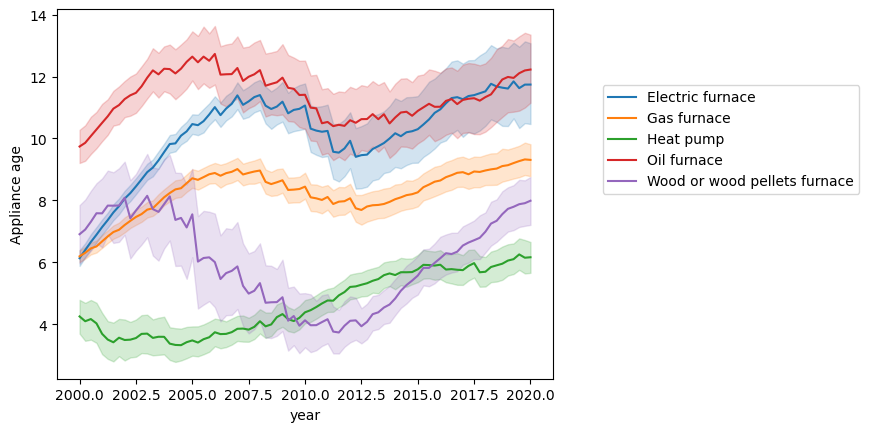

In [8]:
import seaborn as sns
ax = sns.lineplot(b_result.results_df[["year","Appliance age","Appliance name"]], x="year",y="Appliance age",hue="Appliance name")
ax.legend(loc=(1.01,0.3))

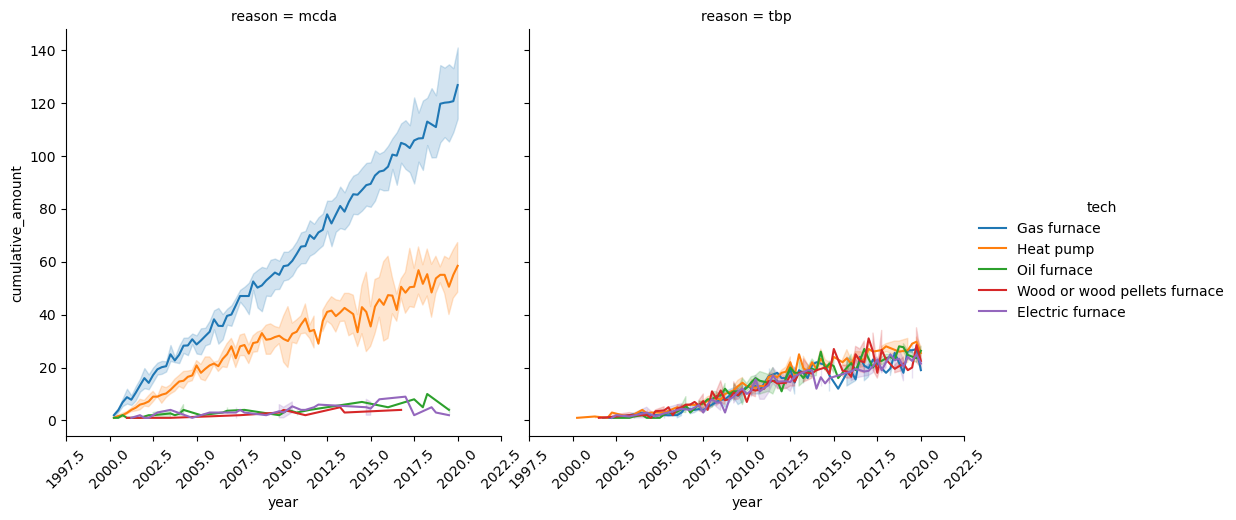

In [7]:
b_result.adoption_details_fig()

In [4]:
b_result.adoption_details_fig_facet(n_facet_cols=3)

## Visualising mutliple confidence intervals as shaded areas

In [4]:
import config
config.TECHNOLOGY_COLORS

{'Gas furnace': '#f7b799',
 'Oil furnace': '#f3d1bf',
 'Wood or wood pellets furnace': '#dde1f4',
 'Electric furnace': '#c4e8cb',
 'Heat pump': '#b0dbda'}

In [5]:

# fig = adoption_plot_with_quantiles(df2plot, [0.68], mid_line="mean")
# fig.update_layout(width=800)

In [6]:
import config
from matplotlib.colors import to_hex
import plotly.express as px
hex_colors = []
technology_colors = config.TECHNOLOGY_COLORS.copy()
for k,c in config.TECHNOLOGY_COLORS.items():
    c_hex = c
    # c_tuple = px.colors.unlabel_rgb(c)
    # c_tuple = [color/255 for color in c_tuple]
    # c_hex = to_hex(c_tuple)
    hex_colors.append(c_hex)
    technology_colors[k] = c_hex

technology_colors



{'Gas furnace': '#f7b799',
 'Oil furnace': '#f3d1bf',
 'Wood or wood pellets furnace': '#dde1f4',
 'Electric furnace': '#c4e8cb',
 'Heat pump': '#b0dbda'}

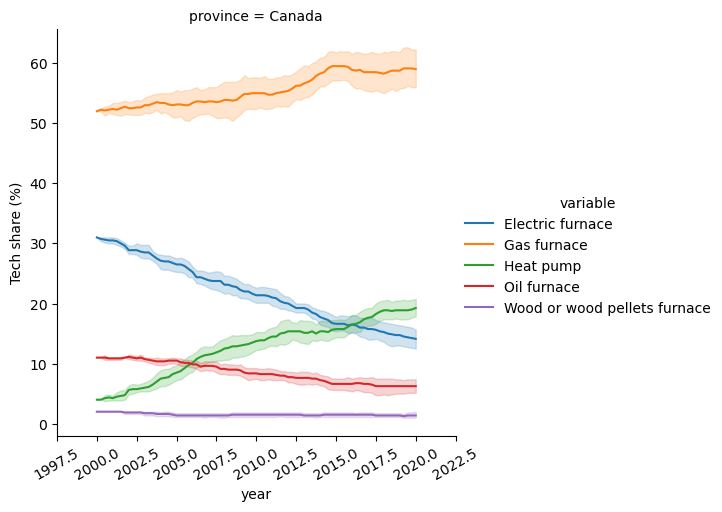

In [7]:
b_result.tech_shares_fig()

## Loading a batch result

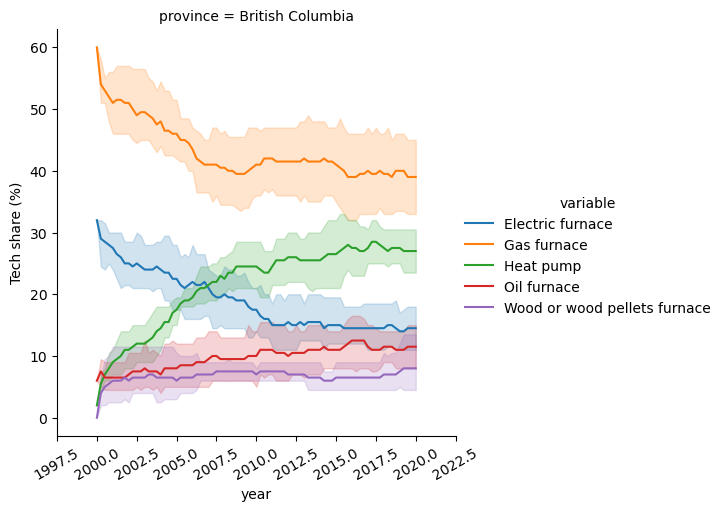

In [15]:
import seaborn as sns
import plotly.express as px
from batch import BatchResult

r_result = BatchResult.from_directory("results/feature_improve_io/3f0ab9dd2ec9beb1f85c4735d52ae41f")

ax = r_result.tech_shares_fig()
ax


# Segregation

In [17]:
from components.model import TechnologyAdoptionModel
from components.technologies import merge_heating_techs_with_share
heating_techs = merge_heating_techs_with_share()

In [26]:
n_agents = 500
n_segregation_steps = 40

model = TechnologyAdoptionModel(n_agents, "Ontario")
income_segregation_dfs = model.perform_segregation(n_segregation_steps, capture_attribute="disposable_income")

(<Axes: >, (23, 23))

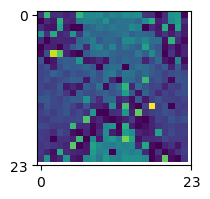

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from itertools import product

fig, ax = plt.subplots(figsize=(3,2))

img = income_segregation_dfs[-1].values
ax.imshow(img, label="income")
ax.set_yticks((0,img.shape[0]))
ax.set_xticks((0,img.shape[1]))
ax,img.shape,

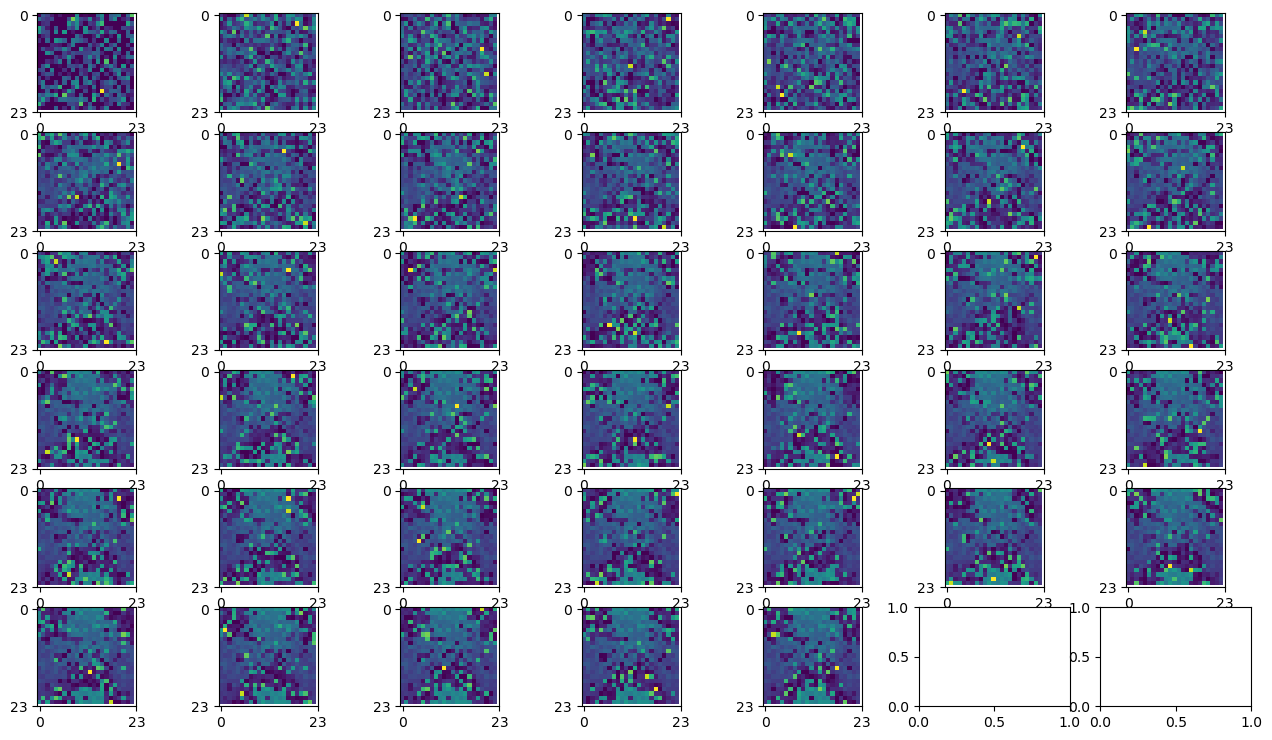

In [28]:
n_rows = int(n_segregation_steps**(1/2)) 
n_cols = n_rows +1


m_idx = list(product(range(n_rows), range(n_cols)))

fig, axes = plt.subplots(nrows=n_rows,ncols=n_cols,figsize=(16,9))

for step, income_df in enumerate(income_segregation_dfs):
    row = m_idx[step][0]
    col = m_idx[step][1]

    # values are image data
    img = income_df.values
    axes[row][col].imshow(img)

    # set ticks to only show size
    # (because the axis here, are not really relevant)
    axes[row][col].set_yticks([0,img.shape[0]])
    axes[row][col].set_xticks([0,img.shape[1]])

    # relevant_ticks = ((income_df.values.shape()))

# Parameter fit


In [2]:
from mesa.batchrunner import batch_run
from components.model import TechnologyAdoptionModel
from components.probability import beta_with_mode_at
from components.technologies import merge_heating_techs_with_share
from data.canada import nrcan_tech_shares_df

import plotly.express as px
import pandas as pd
import numpy as np
from batch import (
    transform_dict_column,
)
import plotly.graph_objects as go
import seaborn as sns

province = "Canada"
start_year = 2000

heat_techs_df = merge_heating_techs_with_share(start_year=start_year, province=province)
historic_tech_shares = nrcan_tech_shares_df.copy()
historic_tech_shares.index = historic_tech_shares.index.swaplevel()
h_tech_shares = historic_tech_shares.loc[province,:]/100


n_steps = 80
def comparison_plot(mean_df):
    historic_tech_shares = nrcan_tech_shares_df.copy()
    historic_tech_shares.index = historic_tech_shares.index.swaplevel()
    h_tech_shares = historic_tech_shares.loc[province,:]/100

    h_tech_shares_long = h_tech_shares.melt(ignore_index=False)
    h_tech_shares_long["comparison"] = "historic"

    mean_df.long = mean_df.melt(ignore_index=False)
    mean_df.long["comparison"] = "modelled"

    comp_df = pd.concat([h_tech_shares_long,mean_df.long])
    ax = sns.lineplot(comp_df.reset_index(),x="index",hue="variable", y="value", style="comparison")
    ax.legend(loc=(1,.25))
    return ax.get_figure()

def get_adoption_details_from_batch_results(model_vars_df):
    adoption_detail = model_vars_df[["Step","RunId","Adoption details","AgentID"]]
    adoption_detail.loc[:,["tech","reason"]] = pd.DataFrame.from_records(adoption_detail["Adoption details"].values)
    adoption_detail = adoption_detail.drop("Adoption details", axis=1)
    adoption_detail["amount"] = 1
    drop_rows = adoption_detail["tech"].apply(lambda x: x is None)
    adoption_detail = adoption_detail.loc[~drop_rows,:]

    adoption_detail = adoption_detail.groupby(["Step","RunId","tech","reason"]).sum().reset_index()

    # get cumulative sum
    adoption_detail["cumulative_amount"] = adoption_detail.groupby(["RunId","tech","reason"]).cumsum()["amount"]
    return adoption_detail

In [3]:
techs = heat_techs_df.index.to_list()
tech_mode_map = dict(zip(techs,[0.5]*len(techs)))

batch_parameters = {
    "N": [200],
    "province": [province],  # , "Alberta", "Ontario"],
    "random_seed": range(20, 28),
    "start_year": start_year,
    "tech_attitude_dist_func":[beta_with_mode_at], 
    "tech_attitude_dist_params":[tech_mode_map],
    "n_segregation_steps" : [30],
    "interact" : [True],
}

adoption_share_dfs = []
adoption_detail_dfs = []

mode_shift = 0.15
best_abs_diff = 1e12
greatest_diff_sum = None
for i in range(7):
    results = batch_run(
        TechnologyAdoptionModel,
        batch_parameters,
        number_processes=None,
        max_steps=80,
        data_collection_period=1,
    )
    df = pd.DataFrame(results)
    df_no_dict, columns = transform_dict_column(df, dict_col_name="Technology shares")
    df2plot = df_no_dict[["RunId", "Step", *columns]].drop_duplicates()
    df2plot = df2plot.melt(id_vars=["RunId", "Step"]).pivot(
        columns=["variable", "RunId"], index="Step", values="value"
    )
    
    adoption_detail_dfs.append(get_adoption_details_from_batch_results(df))

    mean_df = pd.DataFrame()
    for col in df2plot.columns.get_level_values(0).unique():
        mean_df.loc[:,col] = df2plot[col].mean(axis=1)

    mean_df.index = TechnologyAdoptionModel.steps_to_years_static(batch_parameters["start_year"],range(81),1/4)
    diff_sum = (h_tech_shares-mean_df).sum()
    
    current_abs_diff = diff_sum.abs().sum()
    print(i,current_abs_diff)
    
    if greatest_diff_sum is not None:
        if diff_sum.abs().sum() > greatest_diff_sum.abs().sum():
            greatest_diff_sum = diff_sum.copy()
    else:
        greatest_diff_sum = diff_sum.copy()


    if best_abs_diff < current_abs_diff:
        print("Performance degradation. Scaling down mode_shift")
        mode_shift = mode_shift/2
        att_update = att_update/2
        tech_mode_map = best_modes.to_dict()
    else:
        best_abs_diff = current_abs_diff
        if "new_modes" in locals():
            best_modes = new_modes.copy()
        att_update = diff_sum/greatest_diff_sum.abs().max()*mode_shift
    new_modes = pd.Series(tech_mode_map) + att_update


    mean_df["iteration"] = i
    adoption_share_dfs.append(mean_df)

    new_modes[new_modes<=0] = 0.05
    new_modes[new_modes>=1] = 0.95
    debug_info = pd.concat([diff_sum.rename("diff_sum"),new_modes.rename("new_modes")], axis=1,)
    print(i,debug_info)
    tech_mode_map = new_modes.to_dict()
    batch_parameters["tech_attitude_dist_params"] = [tech_mode_map]

100%|██████████| 8/8 [00:11<00:00,  1.48s/it]


0 5.978260044052733
0                               diff_sum  new_modes
Electric furnace              2.955810   0.650000
Gas furnace                  -1.139284   0.442184
Heat pump                    -1.478209   0.424985
Oil furnace                  -0.371877   0.481128
Wood or wood pellets furnace  0.033080   0.501679


100%|██████████| 8/8 [00:13<00:00,  1.71s/it]


1 3.3945100440527334
1                               diff_sum  new_modes
Electric furnace              1.617060   0.732062
Gas furnace                  -0.919284   0.395533
Heat pump                    -0.580709   0.395515
Oil furnace                  -0.197502   0.471105
Wood or wood pellets furnace  0.079955   0.505736


100%|██████████| 8/8 [00:17<00:00,  2.16s/it]


2 2.2357600440527334
2                               diff_sum  new_modes
Electric furnace              1.021435   0.783897
Gas furnace                  -0.258034   0.382438
Heat pump                    -0.631334   0.363476
Oil furnace                  -0.228752   0.459497
Wood or wood pellets furnace  0.096205   0.510618


100%|██████████| 8/8 [00:14<00:00,  1.86s/it]


3 1.563068814599598
3                               diff_sum  new_modes
Electric furnace             -0.381065   0.764559
Gas furnace                   0.668216   0.416348
Heat pump                    -0.400709   0.343141
Oil furnace                   0.011248   0.460068
Wood or wood pellets furnace  0.101830   0.515786


100%|██████████| 8/8 [00:17<00:00,  2.18s/it]


4 1.6720100440527328
Performance degradation. Scaling down mode_shift
4                               diff_sum  new_modes
Electric furnace              0.673935   0.774228
Gas furnace                  -0.391784   0.399393
Heat pump                    -0.333209   0.353309
Oil furnace                  -0.111252   0.459782
Wood or wood pellets furnace  0.161830   0.513202


100%|██████████| 8/8 [00:16<00:00,  2.02s/it]


5 1.4220070265035356
5                               diff_sum  new_modes
Electric furnace              0.580810   0.788965
Gas furnace                  -0.439909   0.388231
Heat pump                    -0.271334   0.346424
Oil furnace                   0.017498   0.460226
Wood or wood pellets furnace  0.112455   0.516056


100%|██████████| 8/8 [00:15<00:00,  1.97s/it]


6 0.9055688145995977
6                               diff_sum  new_modes
Electric furnace             -0.249815   0.782627
Gas furnace                   0.215091   0.393689
Heat pump                    -0.203209   0.341268
Oil furnace                   0.071873   0.462050
Wood or wood pellets furnace  0.165580   0.520257


In [4]:
l_hist_shares = historic_tech_shares.loc[province,:].melt(ignore_index=False).reset_index()
l_hist_shares["iteration"] = "historic"
l_hist_shares["value"] *= 0.01

In [21]:
def parameter_fit_results(dfs: list[pd.DataFrame], second_id_var="iteration"):
    results = pd.concat(dfs)
    results.reset_index(names=["year"], inplace=True)
    long_results = results.melt(id_vars=["year",second_id_var])
    return long_results

pfit_res = parameter_fit_results(adoption_share_dfs)
pfit_res_historic = pd.concat( [pfit_res, l_hist_shares])

fig = px.line(pfit_res, x="year", y="value", color="variable", line_dash="iteration", template="plotly", )

def update_trace_opacity(trace: go.Trace):
    # TODO: add this variable in loop above
    n_fit_iterations = 10
    iteration = trace.name.split(",")[-1]
    if iteration == " historic":
        opacity = 1
        
    else:
        try:
            opacity = int(iteration) * 1/n_fit_iterations
        except:
            pass
            opacity = float(iteration.strip())


    trace.opacity = opacity


fig.for_each_trace(lambda t: update_trace_opacity(t))

for i,tech in enumerate(historic_tech_shares.loc[province,:].columns):
    fig.add_trace(
        go.Scatter(
            x=historic_tech_shares.loc[province,tech].index,
            y=historic_tech_shares.loc[province,tech].values/100,
            mode="lines",
            name=f"{tech}, historic",
            line=dict(dash="solid", width=3, color=px.colors.qualitative.Plotly[i]),
        )
    )

fig.update_layout(width=800)

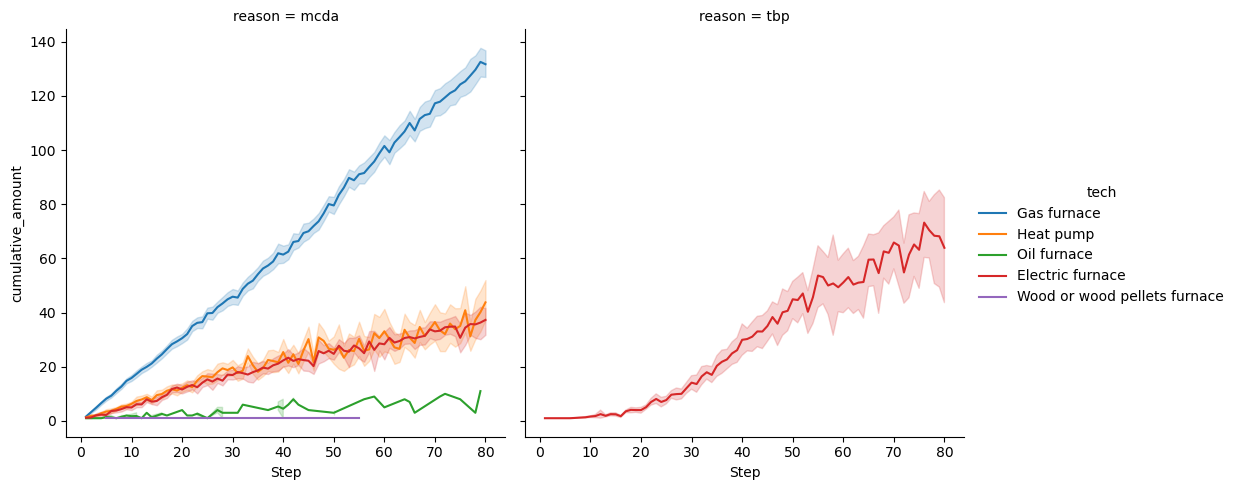

In [6]:
adoption_detail_df = pd.concat(adoption_detail_dfs)
sns.relplot(adoption_detail_df,kind="line", x="Step", y="cumulative_amount", hue="tech", col="reason")
# sns.lineplot(adoption_detail_df, x="Step", y="cumulative_amount", hue="tech")

## Draw dependent random parameters (mcda weights)

weights for mcda need to be diverse across agents, and have to add up to 1.
This can be achieved, by drawing one weight $w_0$ from an assumed distribution D between 0 and 1, and then drawing $w_i$ from the same distribution with adapted boundaries as $1 - w_0$ for the upper bound. More formally, the equation for the upper bound of $w_i$ is:
$$ 1- \sum_{i-1} w_{i-1} $$



In [7]:
from components.model import get_income_and_attitude_weights

all_dfs = []
for p_mode in [0.5, 0.7, 0.9]:
    _, weights_df = get_income_and_attitude_weights(10000, price_weight_mode=p_mode)
    weights_df["mode"] = p_mode
    # print(weights_df.head())
    all_dfs.append(weights_df.copy())

all_df = pd.concat(all_dfs)

fig = px.histogram(
    all_df.melt(id_vars=["mode"]),
    facet_col="variable",
    facet_row="mode",
    category_orders={
        "variable": ["cost_norm", "emissions_norm", "attitude"],
        "mode": [0.5, 0.7, 0.9][::-1],
    },
)
fig.update_layout(template="plotly", xaxis_title="test", width=800)

## parameter fit for mcda-weight's mode

In [ ]:
# new_modes
# Electric furnace                0.766605
# Gas furnace                     0.504180
# Heat pump                       0.146975
# Oil furnace                     0.568051
# Wood or wood pellets furnace    0.514014

Electric furnace                0.766605
Gas furnace                     0.504180
Heat pump                       0.146975
Oil furnace                     0.568051
Wood or wood pellets furnace    0.514014
dtype: float64

In [20]:
from batch import transform_dict_column
province = "Canada"
start_year = 2000

batch_parameters = {
    "N": [150],
    "province": [province],  # , "Alberta", "Ontario"],
    "random_seed": range(20, 28),
    "tech_attitude_dist_func":[beta_with_mode_at], 
    "tech_attitude_dist_params":[best_modes.to_dict()],
    "n_segregation_steps": [30],
    "interact": [False],
}

adoption_dfs = []
for p_mode in [0.925, 0.9, 0.875, 0.85, ]:

    batch_parameters["price_weight_mode"] = p_mode

    results = batch_run(
        TechnologyAdoptionModel,
        batch_parameters,
        number_processes=None,
        max_steps=80,
        data_collection_period=1,
    )
    df = pd.DataFrame(results)
    df_no_dict, columns = transform_dict_column(df, dict_col_name="Technology shares")
    df2plot = df_no_dict[["RunId", "Step", *columns]].drop_duplicates()
    df2plot = df2plot.melt(id_vars=["RunId", "Step"]).pivot(
        columns=["variable", "RunId"], index="Step", values="value"
    )
    
    mean_df = pd.DataFrame()
    for col in df2plot.columns.get_level_values(0).unique():
        mean_df.loc[:,col] = df2plot[col].mean(axis=1)

    mean_df.index = TechnologyAdoptionModel.steps_to_years_static(start_year,range(81),1/4)
    mean_df["p_mode"] = p_mode
    adoption_dfs.append(mean_df)
    diff_sum = (h_tech_shares-mean_df).sum()

    
    total_abs_diff = diff_sum.abs().sum()
    print(p_mode,total_abs_diff)
    # print(f"finished iteration {i}")

mcda_fit_results = pd.concat(adoption_dfs)



100%|██████████| 8/8 [00:11<00:00,  1.38s/it]


0.925 1.7657570265035354


100%|██████████| 8/8 [00:11<00:00,  1.42s/it]


0.9 1.4790903598368685


100%|██████████| 8/8 [00:11<00:00,  1.42s/it]


0.875 1.4174236931702022


100%|██████████| 8/8 [00:11<00:00,  1.42s/it]


0.85 1.4424236931702017


In [22]:
pfit_res = parameter_fit_results(adoption_dfs, second_id_var="p_mode")
pfit_res_historic = pd.concat( [pfit_res, l_hist_shares])
pfit_res_historic["p_mode"][pfit_res_historic["p_mode"].isna()] = "historic"
fig = px.line(pfit_res_historic, x="year", y="value", color="variable", line_dash="p_mode", template="plotly", )

fig.for_each_trace(lambda t: update_trace_opacity(t))

fig.update_layout(width=800)

/tmp/ipykernel_16164/3287833502.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_16164/3287833502.py:3: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'historic' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.



In [25]:
from batch import BatchResult
best_guess_parameters = {
    "N": [200],
    "province": [province],  # , "Alberta", "Ontario"],
    "random_seed": range(20, 28),
    "tech_attitude_dist_func":[beta_with_mode_at], 
    "tech_attitude_dist_params":[best_modes.to_dict()],
    "n_segregation_steps": [30],
    "interact": [False],
    "price_weight_mode": 0.875
}
results = batch_run(
        TechnologyAdoptionModel,
        best_guess_parameters,
        number_processes=None,
        max_steps=80,
        data_collection_period=1,
    )


100%|██████████| 8/8 [00:14<00:00,  1.75s/it]


AttributeError: 'list' object has no attribute 'items'

In [27]:
# best_guess_parameters.pop("tech_attitude_dist_func")
bResult = BatchResult(best_guess_parameters, results)

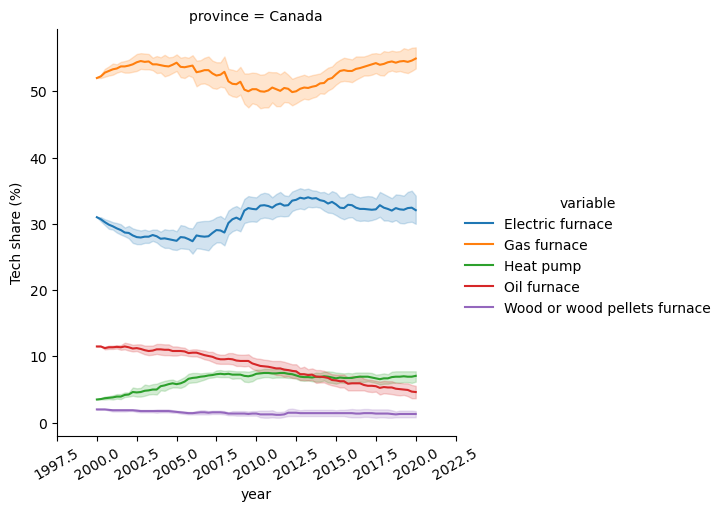

In [38]:
ax = bResult.tech_shares_fig()

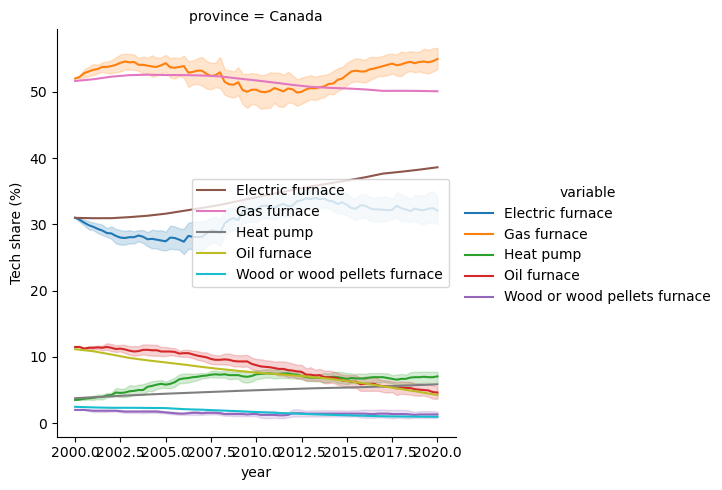

In [39]:
ax_ = historic_tech_shares.loc[province,:].plot(kind="line", ax=ax.ax)
ax_.figure